In [1]:
# Check time stamps
# Inspect data and visualize the time stamps of the data

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tdf = pd.read_csv('data/DailyDelhiClimateTrain.csv', parse_dates=["date"], index_col="date")

In [4]:
df=pd.DataFrame(index=tdf.index)

In [5]:
df['humidity']=tdf['humidity']


In [5]:
df

,humidity
date,
2013-01-01,84.500000
2013-01-02,92.000000
2013-01-03,87.000000
2013-01-04,71.333333
2013-01-05,86.833333
...,...
2016-12-28,68.043478
2016-12-29,87.857143
2016-12-30,89.666667


In [ ]:
df.isnull().sum()

humidity    0
dtype: int64

In [9]:
df.index.duplicated().sum()  # check for duplicate timestamps

0

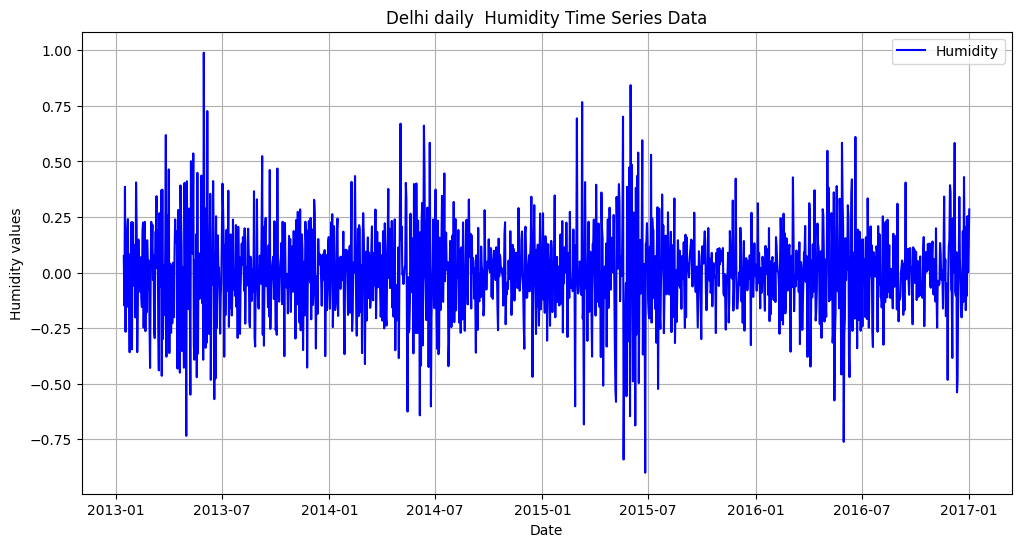

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["humidity"], label="Humidity", color="blue")
plt.title("Delhi daily  Humidity Time Series Data")
plt.xlabel("Date")
plt.ylabel("Humidity values")
plt.grid(True)
plt.legend()
plt.show()

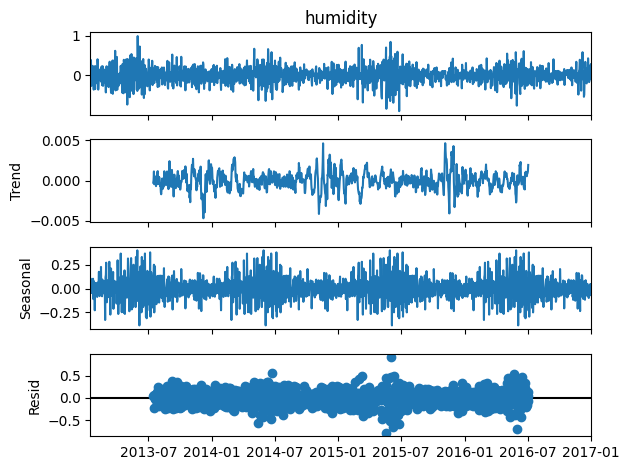

'result2.plot()\nplt.show()'

In [32]:
"""
Performs exploratory data analysis (EDA) by decomposing the electric production time series data.

- Uses seasonal_decompose from statsmodels to split the 'IPG2211A2N' column of the DataFrame 'tdf' into trend, seasonal, and residual components.
- Assumes monthly data with a period of 12.
- Plots the decomposition results for visual inspection of trend and seasonality.
- We use the additive model because the seasonality is constant—that is, the seasonal effect in electricity 
  production increases by a fixed amount each year, rather than changing proportionally with the overall trend.
Returns:
    None. Displays a decomposition plot.
"""
# EDA
from statsmodels.tsa.seasonal import seasonal_decompose
df =df.dropna()
# Decompose the time series data
result = seasonal_decompose(df["humidity"], model='additive', period=365)# additive model in this case will give A good residual plot = random noise → model fits well.   
#result2 = seasonal_decompose(df["humidity"], model='multiplicative', period=365) # the residual plot does not show proper random noise in this case ->multiplicative model does not fit well
# Plot decomposition
result.plot()

plt.show() 
'''result2.plot()
plt.show()'''


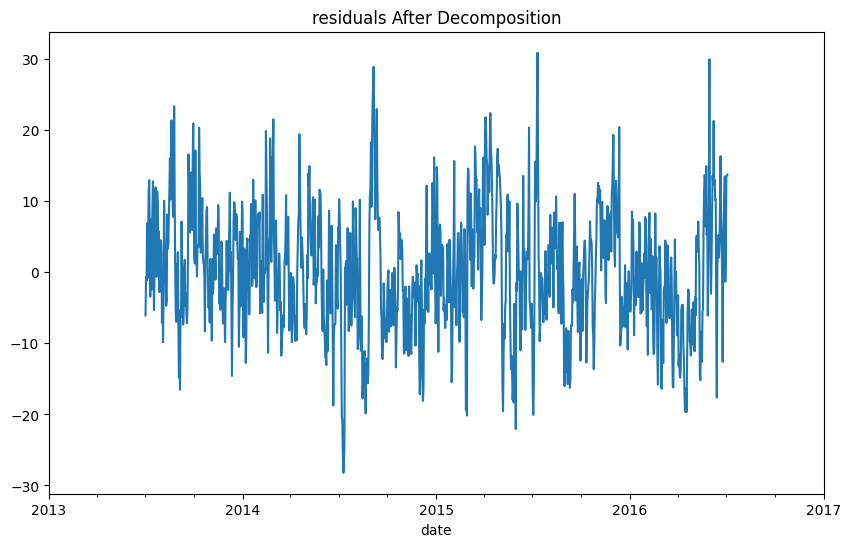

date
2014-07-10   -28.204366
2014-07-11   -26.935171
2014-09-04    26.458395
2014-09-05    28.913735
2015-07-11    30.892121
2016-05-30    29.982663
Name: resid, dtype: float64


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose 
result = seasonal_decompose(df["humidity"], model='additive', period=365)
residual = result.resid

# Plot residuals
residual.plot(figsize=(10, 6))
plt.title("residuals After Decomposition")
plt.show()


# Detect large residuals
outliers = residual[np.abs(residual) > 3 * residual.std()]
print(outliers)

Skewness: -0.34362423369234935
Kurtosis: -0.3130539967546011


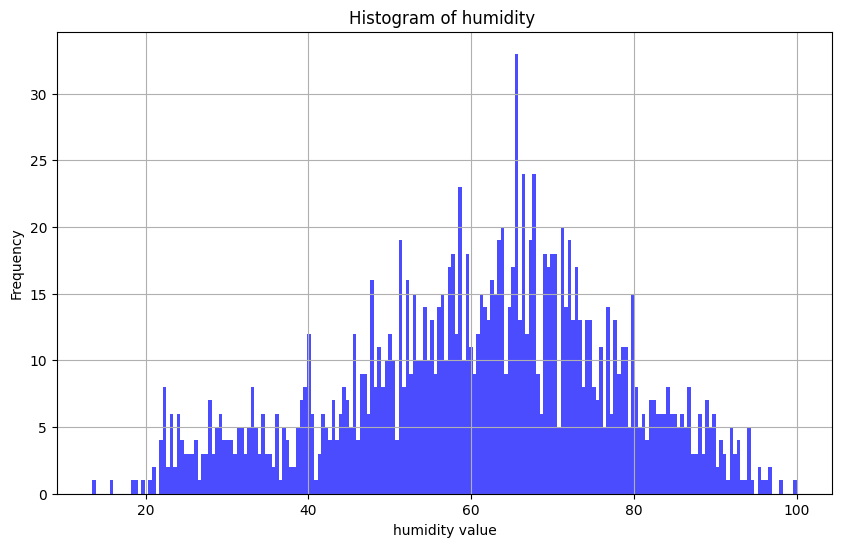

In [10]:
# Checking skewness and kurtosis


from scipy.stats import skew, kurtosis
# Calculate skewness and kurtosis
skewness = skew(df["humidity"])
kurt = kurtosis(df["humidity"])
print("Skewness:", skewness)
print("Kurtosis:", kurt)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(tdf["humidity"], bins=200, color='blue', alpha=0.7)
plt.title("Histogram of humidity ")
plt.xlabel("humidity value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show() 

In [11]:
print(df["humidity"].mean())
print(df["humidity"].median())
df["humidity"].mode()


60.77170158004638
62.625


0    65.5
Name: humidity, dtype: float64

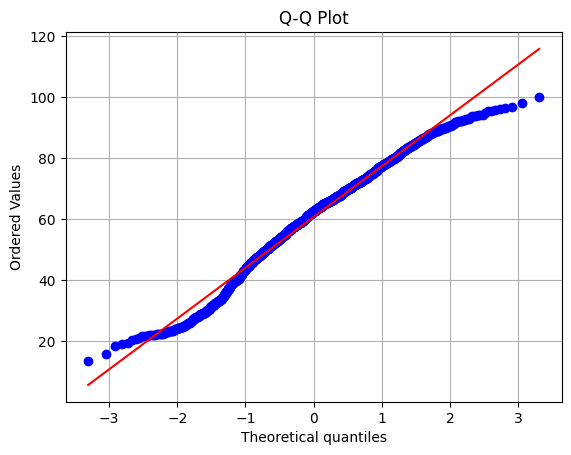

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


data = df["humidity"]



# Create Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.grid(True)
plt.show()


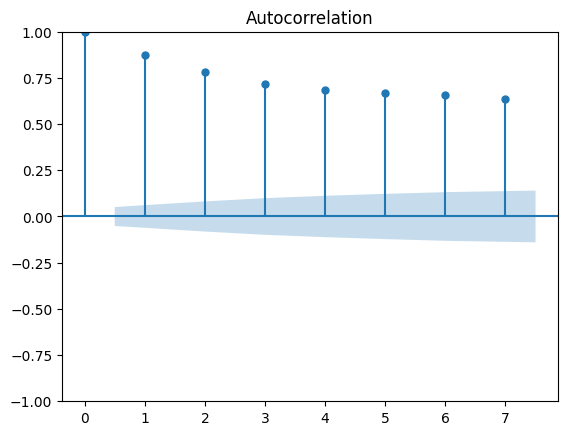

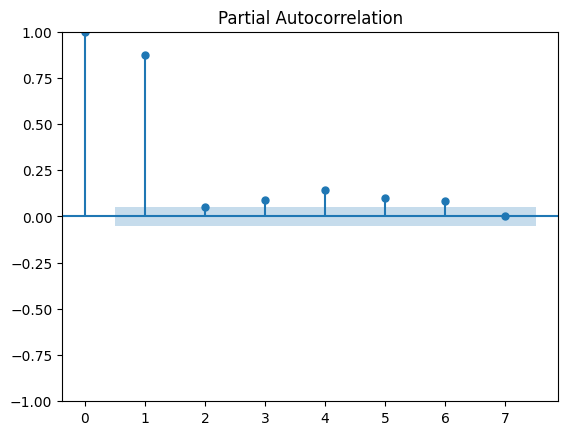

In [13]:
# subtracting the current value from the previous value
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["humidity"], lags=7)
plt.show()

plot_pacf(df["humidity"], lags=7)
plt.show()

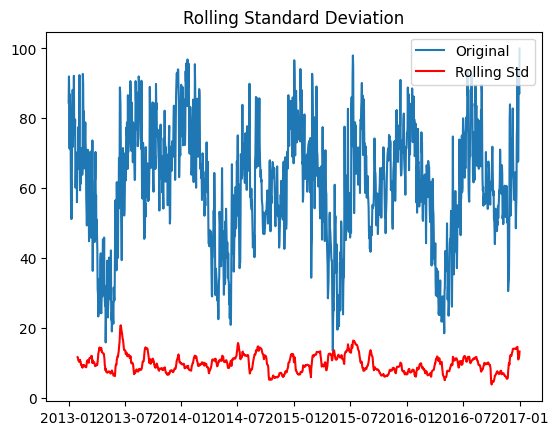

In [23]:
# checking for variance
#A rolling (or moving) standard deviation is a technique used in time series analysis to observe how the volatility (variability) of a time series changes over time.
rolling_std = df["humidity"].rolling(window=30).std()
plt.plot(tdf["humidity"], label='Original')
plt.plot(rolling_std, label='Rolling Std', color='red')
plt.legend()
plt.title("Rolling Standard Deviation")
plt.show() 
#A higher rolling std deviation at a time period shows higher variability (volatility) in that part of the serie
#For a stationary series, the rolling standard deviation should be roughly constant over time.
# WE get a Rising/falling rolling std deviation → Non-stationary variance → May need transformation (e.g., log, differencing).

In [15]:
# checking if the data is stationary
from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(df["humidity"])
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

"""
Performs the Augmented Dickey-Fuller test to check for stationarity of a time series.

The null hypothesis of the ADF test is that the time series is non-stationary.
A low p-value (typically ≤ 0.05) indicates that the null hypothesis can be rejected,
meaning the time series is likely stationary. Conversely, a p-value > 0.05 suggests
the time series is non-stationary.

If ADF Statistic < '1%' value → Very strong evidence for stationarity.

If ADF Statistic < '5%' value → Moderate evidence for stationarity.

If ADF Statistic < '10%' value → Weak evidence for stationarity.

If ADF Statistic > '10%' value → Fail to reject → Non-stationary.



Args:
    timeseries (pd.Series): The time series data to be tested.

Returns:
    None. Prints the ADF statistic and p-value.
    Prints a statement indicating whether the time series is stationary based on the p-value.
"""


ADF Statistic: -3.6755769191633414
p-value: 0.004470100478130723
Critical Values: {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}
THe result is stationary


"\nPerforms the Augmented Dickey-Fuller test to check for stationarity of a time series.\n\nThe null hypothesis of the ADF test is that the time series is non-stationary.\nA low p-value (typically ≤ 0.05) indicates that the null hypothesis can be rejected,\nmeaning the time series is likely stationary. Conversely, a p-value > 0.05 suggests\nthe time series is non-stationary.\n\nIf ADF Statistic < '1%' value → Very strong evidence for stationarity.\n\nIf ADF Statistic < '5%' value → Moderate evidence for stationarity.\n\nIf ADF Statistic < '10%' value → Weak evidence for stationarity.\n\nIf ADF Statistic > '10%' value → Fail to reject → Non-stationary.\n\n\n\nArgs:\n    timeseries (pd.Series): The time series data to be tested.\n\nReturns:\n    None. Prints the ADF statistic and p-value.\n    Prints a statement indicating whether the time series is stationary based on the p-value.\n"

In [43]:
"""
KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin Test)

The KPSS test is a statistical test used to check the stationarity of a time series. 
It tests whether a time series is stationary around a mean (level stationarity) or around a deterministic trend (trend stationarity).

How it works:
- The test statistic is calculated based on the residuals from the regression of the time series on a constant (or constant and trend).
- The test compares the test statistic to critical values to determine if the null hypothesis can be rejected.

Hypotheses:
- Null Hypothesis (H0): The time series is stationary (level or trend stationary).
- Alternative Hypothesis (H1): The time series is non-stationary (has a unit root).

Significance Value:
- A typical significance level (alpha) is 0.05.
- If the p-value is less than 0.05, reject the null hypothesis and conclude the series is non-stationary.
"""

result_kpss = kpss(df["humidity"])
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])

KPSS Statistic: 0.09173654899480822
p-value: 0.1


C:\Users\injil\AppData\Local\Temp\ipykernel_11440\443254418.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(df["humidity"])


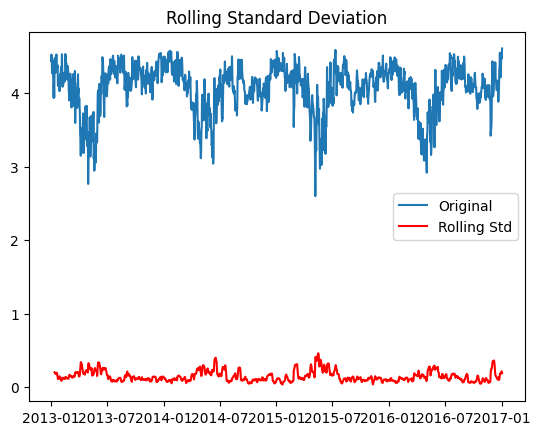

In [26]:
def plot_rolling_std(df:pd.DataFrame):
    rolling_std =df["humidity"].rolling(window=12).std()
    plt.plot(df["humidity"], label='Original')
    plt.plot(rolling_std, label='Rolling Std', color='red')
    plt.legend()
    plt.title("Rolling Standard Deviation")
    plt.show() 
plot_rolling_std(df)

In [6]:
# apply log transformation 
df["humidity"] = np.log(df["humidity"])

In [7]:
df=df.diff().dropna()

In [8]:
df["humidity"] = df["humidity"]  - df["humidity"] .shift(12)


In [33]:
"""
ARCH Test (Autoregressive Conditional Heteroskedasticity Test)

The ARCH test is a statistical test used to detect the presence of autoregressive conditional heteroskedasticity (ARCH) effects in a time series. 
ARCH effects indicate that the variance of the current error term or innovation is related to the variances of previous time periods' error terms, 
which is common in financial and economic time series.

How it works:
- The test fits a regression model to the squared residuals of a time series.
- It checks whether past squared residuals can explain the current squared residual.
- If the test statistic is significant (low p-value), it suggests the presence of ARCH effects (time-varying volatility).

Use case:
- The ARCH test is commonly used before fitting GARCH or other volatility models to determine if modeling conditional heteroskedasticity is necessary.

Hypotheses:
- Null Hypothesis (H0): No ARCH effects (homoskedasticity; constant variance).
- Alternative Hypothesis (H1): Presence of ARCH effects (heteroskedasticity; time-varying variance).
Interpretation:
- A p-value less than the chosen significance level (e.g., 0.05) indicates rejection of the null hypothesis, suggesting the presence of ARCH effects.
"""


# ARCH test
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(df["humidity"].dropna())
print("P-value: ", arch_test[1])
if arch_test[1]<0.05: 
    print("Arch effects present")
else:
    print("Arch effects not present")

print("P-value: ", arch_test[1])

P-value:  7.531749650756599e-18
Arch effects present
P-value:  7.531749650756599e-18


In [51]:
df2=pd.DataFrame(index=df.index)


In [34]:
# removing the trend ---> using the difference method
def test_stationarity(timeseries):
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(timeseries)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    if adf_result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

test_stationarity(df['humidity'].dropna())

ADF Statistic: -13.088157278085882
p-value: 1.811641744876103e-24
The time series is stationary


In [35]:
""" 
Coefficients:

mu: This is the constant term in the mean equation (if you included one). It represents the average value of the series.
omega: This is the constant term in the variance equation. It's the long-run average variance. It must be positive.
alpha[1]: This is the coefficient on the lagged squared residual (the ARCH term). It indicates how much the previous period's shock affects current volatility. It should be positive and less than 1.
beta[1]: This is the coefficient on the lagged conditional variance (the GARCH term). It indicates how much the previous period's volatility affects current volatility. It should be positive and less than 1.
alpha[1] + beta[1]: The sum of these coefficients is crucial. If it's close to 1, it suggests that volatility is very persistent (it takes a long time for shocks to die out). If it's greater than or equal to 1, the model is not stationary, which is a problem.
Significance (P-values):

Look at the p-values associated with each coefficient. A small p-value (typically less than 0.05) indicates that the coefficient is statistically significant, meaning it's unlikely to be zero. Significant coefficients are important for the model.
Model Fit Statistics:

Log-Likelihood: A higher log-likelihood generally indicates a better fit.
AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These are used to compare different models. Lower values indicate a better trade-off between model fit and complexity. If you're comparing different GARCH models (e.g., different orders), use these to help choose the best one.
Diagnostics:

Jarque-Bera Test: This tests whether the residuals are normally distributed. GARCH models assume that the standardized residuals (residuals divided by the conditional standard deviation) are normally distributed. A significant p-value here suggests non-normality, which might indicate a problem with the model or the need for a different distribution.
Ljung-Box Test: This tests for autocorrelation in the residuals and squared residuals. Significant autocorrelation suggests that the model is not capturing all the dependence in the data. If there is autocorrelation in the squared residuals, it suggests that there is still ARCH effect in the residuals, and the model is not correctly specified.
Warnings:

Pay attention to any warnings that the arch library might produce. These warnings can indicate potential problems with the model, such as non-stationarity or convergence issues.
In summary, you're looking for: significant coefficients that make sense in the context of your data, a good model fit (as indicated by the AIC/BIC), and no major violations of the model's assumptions (as indicated by the diagnostic tests).

"""



from arch import arch_model

# Drop NaNs from transformation if needed
series = df["humidity"].dropna()


# Fit GARCH(1,1)
model = arch_model(series, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               humidity   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                326.824
Distribution:                  Normal   AIC:                          -645.647
Method:            Maximum Likelihood   BIC:                          -624.533
                                        No. Observations:                 1449
Date:                Mon, May 26 2025   Df Residuals:                     1448
Time:                        23:41:23   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.8638e-04  4.475e-03 -6.400e-02      0.

i:\CQAI\TSA\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [12]:
ts =df["humidity"]
train = ts[:1099]
test = ts[1099:]  

In [11]:
df = df.dropna()

In [13]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")






stepwise_model = auto_arima(train,
                             seasonal=True, m=365, # monthly seasonality
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(f"\nBest SARIMA model order: {stepwise_model.order} Seasonal Order: {stepwise_model.seasonal_order}")


model = SARIMAX(train,
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Step 6: Model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Step 7: Forecast future values
n_forecast = len(test) 


forecast = results.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
ax = ts.plot(label='Observed', figsize=(12, 5))
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")
plt.show()


Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller




model = ARIMA(train, order=(1, 0, 1))  # choose your (p,d,q)
fitted_model = model.fit()
print(fitted_model.summary())
# 4. Forecast same number of steps as test set
forecast = fitted_model.forecast(steps=len(test))




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
